# Visualizing 272 n-gram probability distributions

N-grams, or n-character-substrings, can be used to automatically detect a given text's origin language. N-grams can also be used at the word level, but here we are looking at the character level. 

Why do we care about n-grams? By simple character frequency analysis, we can make some great features that allow for us to (usually) classify a language as Korean, English, Russian, or what have you. Some of this will be low haning fruit, because, believe it or not, using the frequency of Japanese characters (kana) is a dead give away that the language is Japanese. Korean too, is very easy to detect. 

However, things start to get more tricky since most writing systems or orthographies are shared by a larger group of languages. It gets even trickier when the text is short ! For many languages, unigram, bigram, trigram, and so on frequencies have already been compiled. For many smaller languages, large resources of text are not readily available on the web.

What data should we use? This entire notebook is exploratory/for fun, so we're choosing something small. But we'd also like something that is highly translated (already). Thankfully the NLTK folk have put together a corpus of the Universal Declaration of Human Rights, which aside from its political importance, is one of the most translated documents in the world (well, at least at one point).  However, the domain of language use, by all means, is not reflective of casual speech for example, so it is important to keep that in mind as move forward. Not only are we focusing on a specific domain of language use, but register.

What classifiers should we use? We'll use logistic regression (which is mathematically equivalent to the maximum entropy classifier, which is more commonly referred to in NLP literature) and multinomial naive bayes - both of these are (relatively) simple classifers that can be implemented in a variety of places. 

# Outline

I will walk through calculating n-gram probabilities using the ever popular scikit learn machine learning library. I've commented quite a few of the cells in case you are unfamiliar with some of these libraries.

I personally find that commented code isn't that annoying for someone who knows what is going on, but potentially really helpful for someone who is just getting the hang of the py-data ecosystem. 

Futher more, we will look at visualizing this data from a variety of angles using seaborn and plotly. The analysis is broken up into a few different parts.

1.) ETL - Extraction, transformation and loadying
 - load data
 - clean data
 - extract features
 - create training and testing sets for our classifiers

2.) Classification
 - train some classifiers (training data)
 - evaluate their performance (testing data)
 
3.) Visualize
 - reduce dimensionality
     - PCA
     - TSNE
     - SVD
     - ICA
 - scatter plots
 - bubble plots
 - 3D plots
 

In [1]:
# used to interact with the operating system
import os

# numpy is for numerical operations
import numpy as np

# pandas is for PANel DAta
import pandas as pd

# seaborn is for visualization
import seaborn as sns

# cufflinks is for visualization
# it comes from plotly
import cufflinks as cf

# this makes matplotlib show inline
%matplotlib inline

# used in the ETL process
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer as CV

# used in the classification process
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# used to compare classifiers
from sklearn.metrics import precision_recall_fscore_support

# used in the visualization process
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE



/usr/local/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# ETL



In [2]:
UDHR_CORPUS = "/Users/aljohnson/nltk_data/corpora/udhr/"

In [3]:
FILE_NAMES = [f for f in os.listdir(UDHR_CORPUS) if ('UTF8' in f) or ('Latin1' in f)]

In [4]:
def file_reader(f):
    if 'UTF8' in f:
        with open(UDHR_CORPUS + f, 'r', encoding='UTF8', errors='ignore') as infile:
            blob = infile.readlines()
            return blob
    elif 'Latin1' in f:
        with open(UDHR_CORPUS + f, 'r', encoding='Latin1', errors='ignore') as infile:
            blob = infile.readlines()
            return blob

In [5]:
data = []
for f in FILE_NAMES:
    lines = file_reader(f)
    for line in lines:
        data.append([f, line.strip()])

In [6]:
# Add columns
df = pd.DataFrame(data, columns=['language', 'text'])

# Removing encoding from name
df.language = df.language.map(lambda x: x.split('-')[:-1][0])

# remove ending new lines
df.text = df.text.map(lambda x: x.strip())

In [7]:
df.head()

,language,text
0,Abkhaz,﻿Ауаюытъыюса изин6ъа Зегьеицырзеи8шу Адекларациа
1,Abkhaz,Алагалажъа
2,Abkhaz,"Дызус0заалак, ауаатъыюсатъ 0аацъара иалахъу ищ..."
3,Abkhaz,иара убас ауаюы изин6ъа ратъамбареи хырюаа рым...
4,Abkhaz,иара убас ажълар6ъа реиюызара аизщазыяьара ацх...


In [8]:
df.tail()

,language,text
22752,Zulu,Isigaba 28
22753,Zulu,Wonke umuntu emphakathini nasemhlabeni kumele ...
22754,Zulu,Isigaba 29
22755,Zulu,1. Wonke umuntu uneqhaza emphakathini okuwukup...
22756,Zulu,2. Ekusebenziseni amalungelo nenkululeko yakhe...


In [9]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.language, test_size=0.33, random_state=33)

In [10]:
def rejoin(x, y):
    temp_df = pd.DataFrame.join(pd.DataFrame(y), pd.DataFrame(x))
    data = []
    for language in set(temp_df.language):
        data.append([language,' '.join(temp_df[temp_df.language == language].text)])
        
    return pd.DataFrame(data, columns=['language', 'text'])

In [11]:
# we will use these throughout the notebook
agglomed = rejoin(X_train, y_train)
testing_df = rejoin(X_test, y_test)

In [12]:
# sanity check
len(agglomed), len(testing_df)

(272, 272)

In [13]:
def vectorize_normalize(data, ngram_range=(1,1)):
    vectorizer = CV(analyzer='char', ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(data)
    # divide by row totals for probability
    count_matrix /= count_matrix.sum(axis=1)
    df = pd.DataFrame(count_matrix, columns=vectorizer.get_feature_names())
    return df

In [14]:
ngram_probs_matrix = [vectorize_normalize(agglomed.text, ngram_range=(n,n)) for n in range(1,4)]
ngram_probs = [agglomed.join(p).drop('text', axis=1) for p in ngram_probs_matrix]

In [15]:
def plot_language_distribution(language, n=1, figsize=(20,15), ax=None):
    if language not in agglomed.language.values:
        return 'Not a valid language, dude.'
    # filter
    language_df = ngram_probs[n-1][ngram_probs[n].language == language]
    # drop columns that are zero
    language_df = language_df.loc[:, (language_df != 0).any(axis=0)]
    our_plot = language_df.plot(
        title=language, 
        kind='bar', 
        ax=ax, 
        figsize=figsize, 
        rot=45, 
        colormap='Accent')
    
    # change legend location
    our_plot.legend(loc=0, ncol=15, mode='expand')
    
    # remove x ticks
    our_plot.get_xaxis().set_visible(False)
    
    # set title
    our_plot.set_title(language, fontdict={'fontsize': '25'})
    
    return our_plot

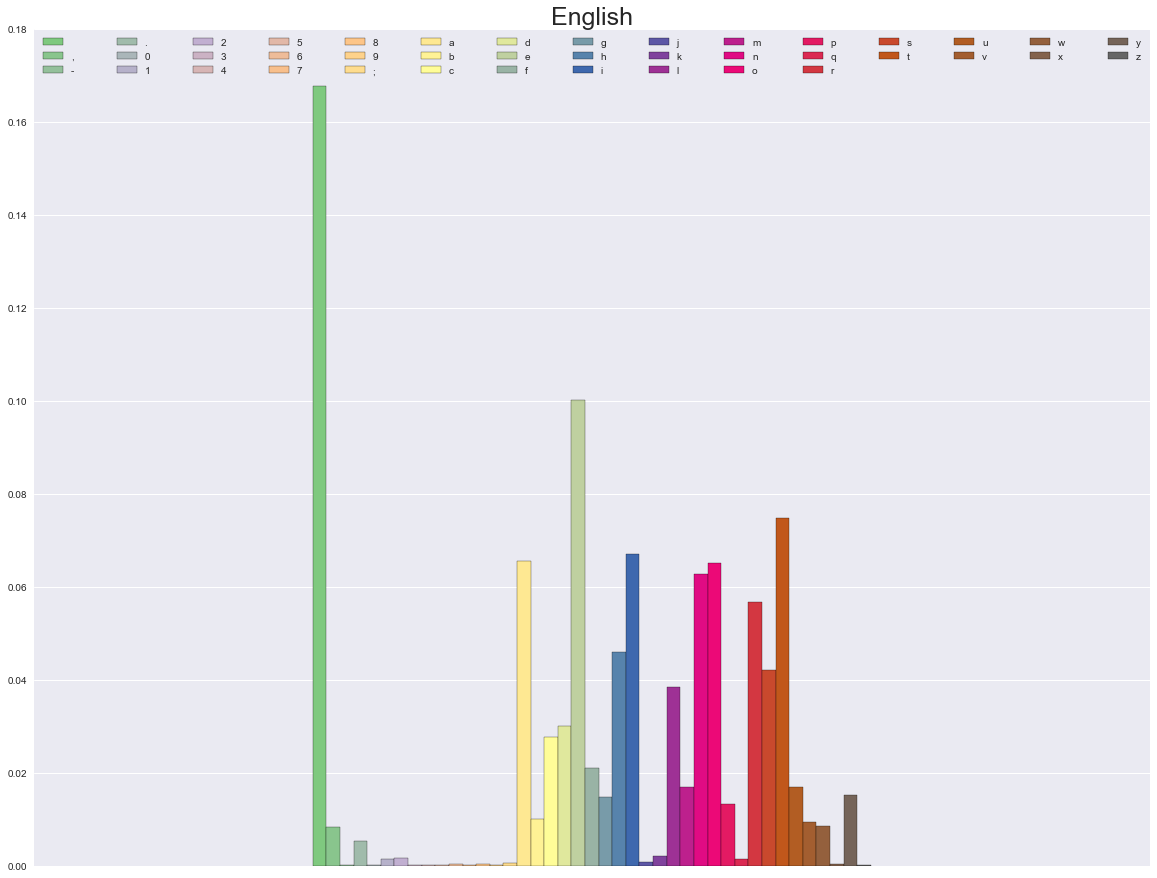

In [16]:
plot_language_distribution('English')


In [17]:
def plot_dists(languages):
    f, axarr = plt.subplots(len(languages))
    for n, l in enumerate(languages):
        plot_language_distribution(l, ax=axarr[n], figsize=(25, 20))

# beware !

The colors dont necessary refer to the same character. So you can't just refer color to color.

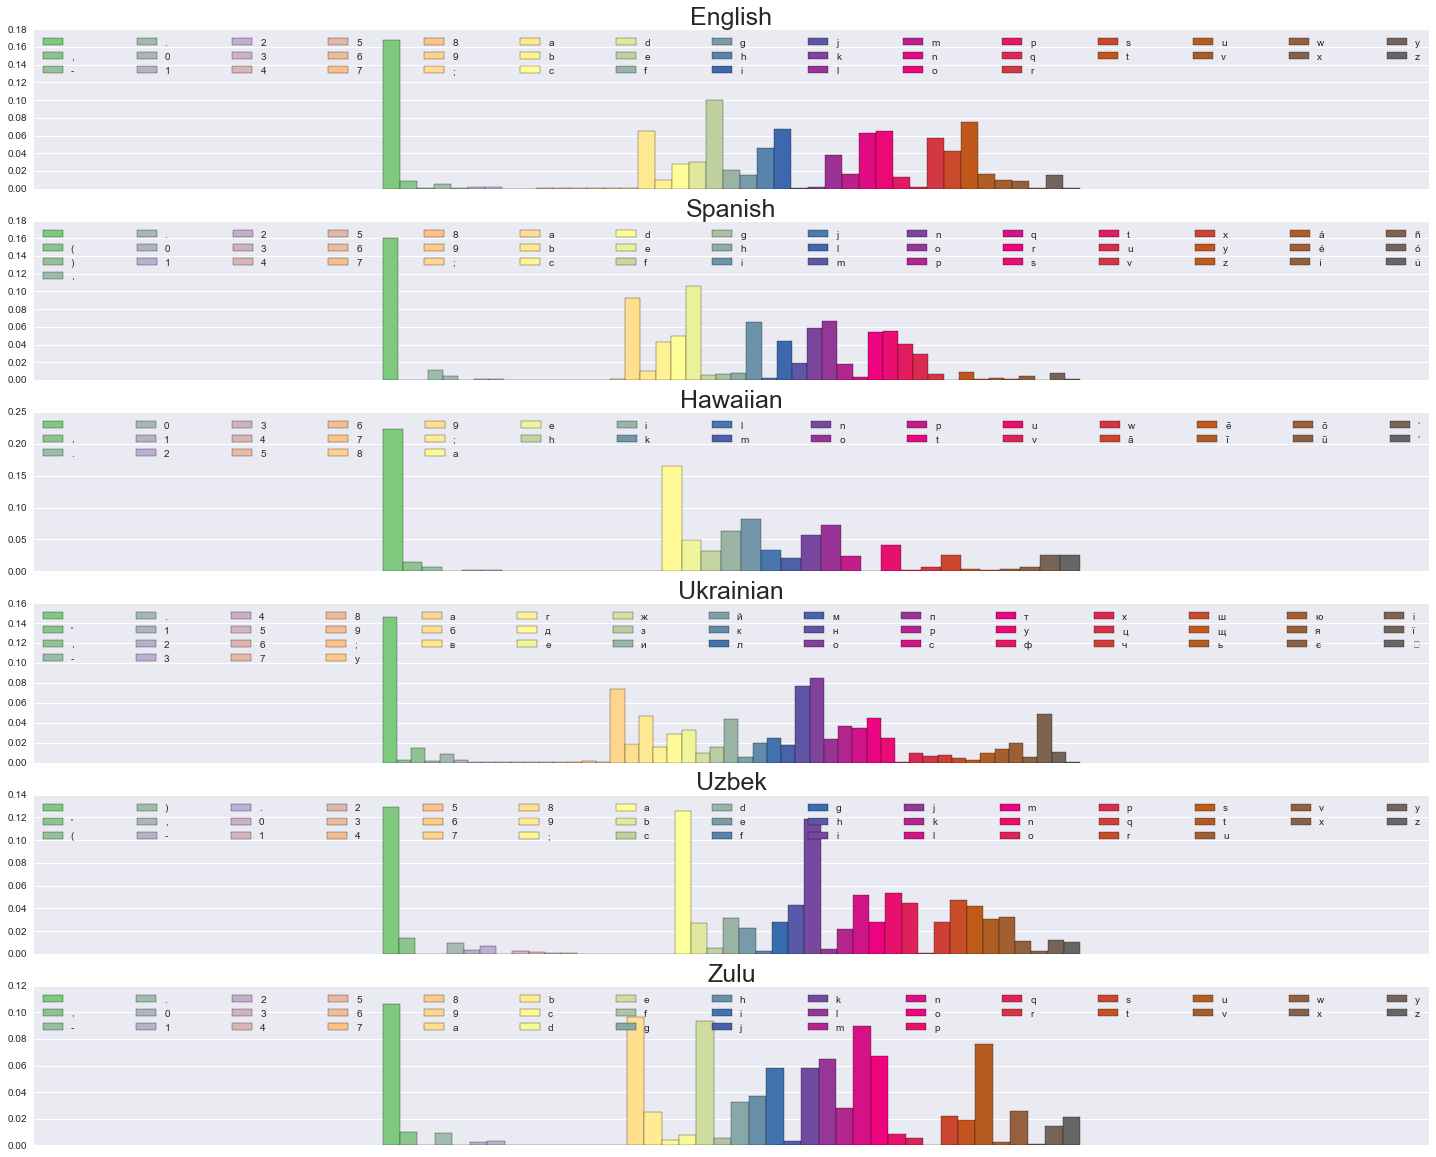

In [18]:
plot_dists(['English', 'Spanish', 'Hawaiian', 'Ukrainian', 'Uzbek', 'Zulu'])

In [19]:
# what other languages could we look at?

In [20]:
agglomed.language.values

array(['Hindi_web', 'Malay_BahasaMelayu', 'Soninke_Soninkanxaane',
       'Filipino_Tagalog', 'Sukuma', 'Mazateco', 'Beti', 'Lamnso_Lam',
       'Ndebele', 'Hmong_Miao', 'Tamil', 'Danish_Dansk', 'Albanian_Shqip',
       'Romani', 'Palauan', 'Dagaare', 'Oromiffa_AfaanOromo', 'Lao',
       'Huitoto_Murui', 'Sinhala', 'Matses', 'Rarotongan_MaoriCookIslands',
       'Catalan', 'Wolof', 'Jola', 'Russian_Russky', 'Mazahua_Jnatrjo',
       'Rukonzo_Konjo', 'Edo', 'Hungarian_Magyar', 'Maltese',
       'Kimbundu_Mbundu', 'Kapampangan', 'Purhepecha', 'Amahuaca',
       'Osetin_Ossetian', 'Bichelamar', 'Chechewa_Nyanja',
       'Mayan_Yucateco', 'French_Francais', 'Campa_Pajonalino', 'Dagbani',
       'Dendi', 'Uzbek', 'Bengali', 'Czech', 'Fijian', 'Yoruba',
       'Ashaninca', 'Adja', 'Kurdish', 'Greek_Ellinika',
       'Garifuna_Garifuna', 'Galician_Galego', 'Somali', 'Dangme',
       'Catalan_Catala', 'Kabye', 'Zhuang', 'Cashinahua', 'Farsi_Persian',
       'Bugisnese', 'Latin_Latina', 'Hausa_

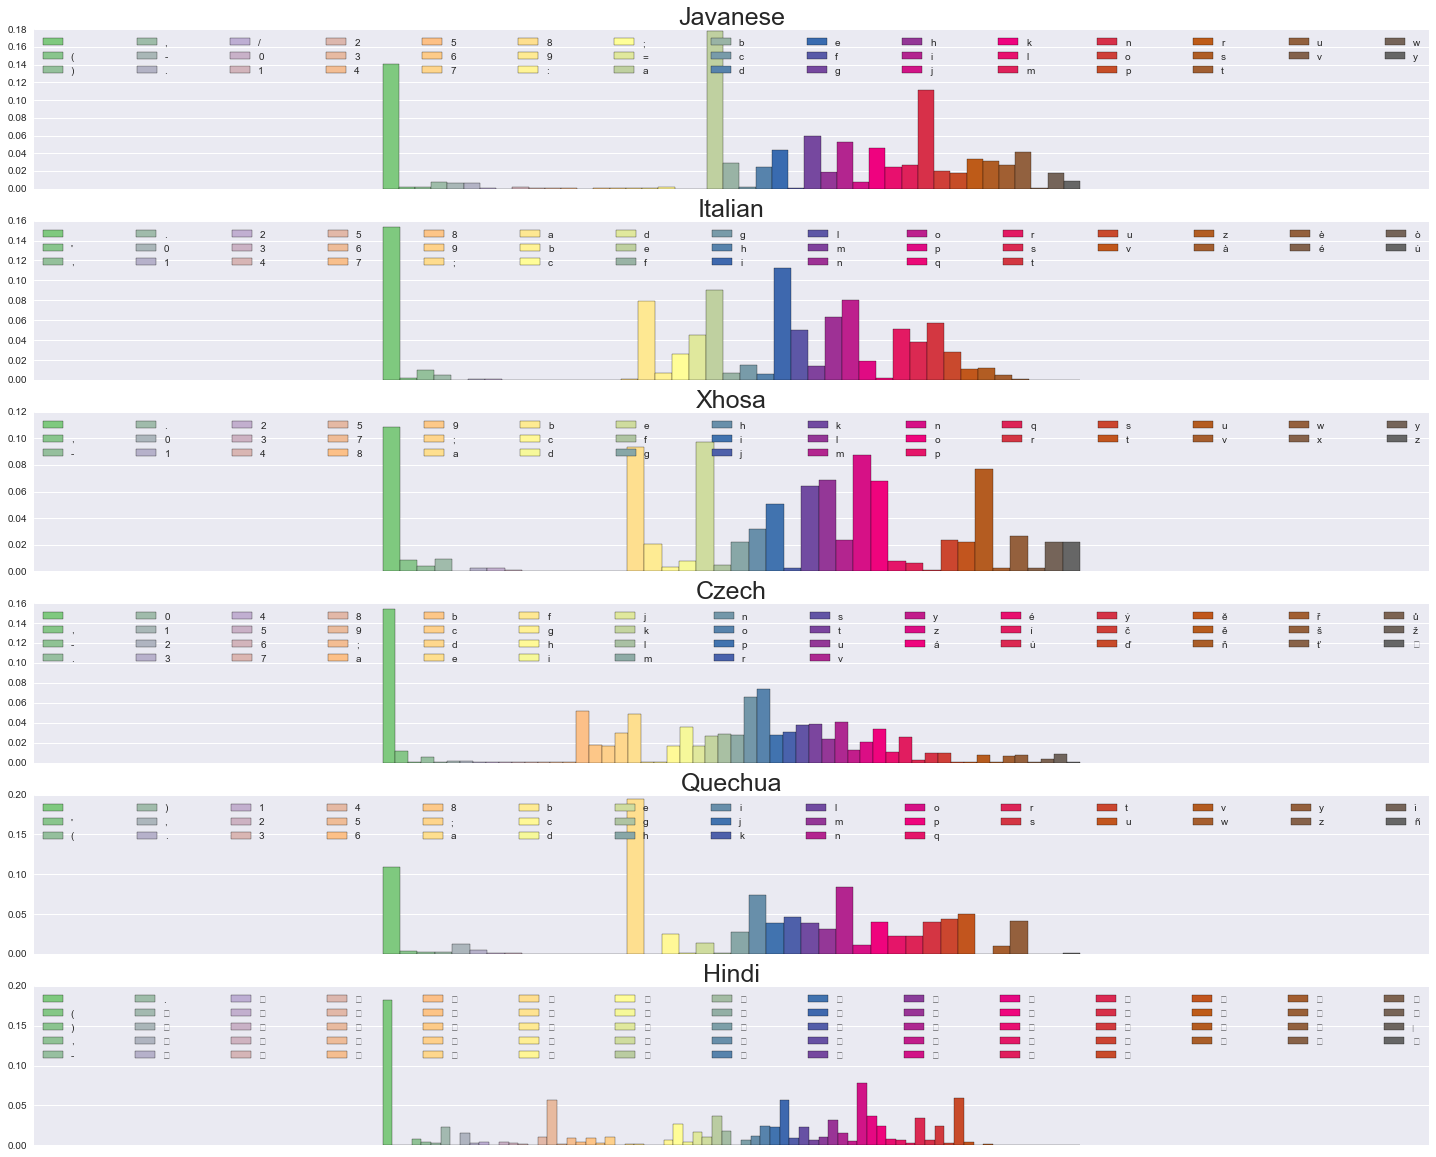

In [21]:
plot_dists(['Javanese', 'Italian', 'Xhosa', 'Czech', 'Quechua', 'Hindi'])

In [22]:
# hmm looks like seaborn / matplotlib only work with certain character sets

# feature selection

We need to do a little more cleaning 

In [23]:
# grab column names and shapes
# remove first feature because its a string, 'language'
ngram_cols = [pdist.drop('language', axis=1).columns for pdist in ngram_probs]
ngram_shapes = [pdist.drop('language', axis=1).shape for pdist in ngram_probs]

In [24]:
ngram_cols

[Index(['\t', ' ', '"', '%', ''', '(', ')', '*', ',', '-',
        ...
        '히', '﻿', '，', '１', '２', '５', '６', '７', '８', '：'],
       dtype='object', length=1721),
 Index(['\tа', '\tн', '\tу', '\tх', '\tດ', ' "', ' '', ' (', ' )', ' *',
        ...
        '﻿အ', '﻿世', '， ', '１条', '２条', '５条', '６条', '７条', '８条', '： '],
       dtype='object', length=14789),
 Index(['\tал', '\tна', '\tул', '\tхv', '\tхэ', '\tດ້', ' " ', ' "a', ' "c',
        ' "d',
        ...
        '， 大', '， 并', '， 联', '１条 ', '２条 ', '５条 ', '６条 ', '７条 ', '８条 ', '： 第'],
       dtype='object', length=66427)]

In [25]:
# get them empty features
empty_features = [pd.DataFrame(np.zeros(shape), columns=cols) 
                  for (shape, cols) in zip(ngram_shapes, ngram_cols)]

In [26]:
# sanity check
[(shape, f.head(1)) for (shape, f) in zip(ngram_shapes, empty_features)]

[((272, 1721),
     \t     "  %  '  (  )  *  ,  - ...  히  ﻿  ，  １  ２  ５  ６  ７  ８  ：
  0   0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
  
  [1 rows x 1721 columns]),
 ((272, 14789),
     \tа  \tн  \tу  \tх  \tດ   "   '   (   )   * ...  ﻿အ  ﻿世  ，   １条  ２条  ５条  \
  0    0    0    0    0    0   0   0   0   0   0 ...   0   0   0   0   0   0   
  
     ６条  ７条  ８条  ：   
  0   0   0   0   0  
  
  [1 rows x 14789 columns]),
 ((272, 66427),
     \tал  \tна  \tул  \tхv  \tхэ  \tດ້   "    "a   "c   "d ...   ， 大  ， 并  ， 联  \
  0     0     0     0     0     0     0    0    0    0    0 ...     0    0    0   
  
     １条   ２条   ５条   ６条   ７条   ８条   ： 第  
  0    0    0    0    0    0    0    0  
  
  [1 rows x 66427 columns])]

# train our classifiers

In [27]:
# logistic regression initalization for each n-gram
logistic_clfs = [LogisticRegression(), LogisticRegression(), LogisticRegression()]

# multinomial naive bayes initlization for each n-gram
mnb_clfs = [MultinomialNB(), MultinomialNB(), MultinomialNB()]

classifier_groups = [logistic_clfs, mnb_clfs]

# this is for fitting really - the scoring doesnt mean much on a training set
for group in classifier_groups:
    print('*%'*35)
    print('Classifier: {}\n'.format(group[0]))
    
    for i, clf in enumerate(group):
        dist = ngram_probs_matrix[i]
        clf.fit(dist, agglomed.language)
        
        # get the training scores
        predictions = clf.predict(dist)
        score = precision_recall_fscore_support(agglomed.language, predictions, average='micro')
        
        print('='*70)
        print('n-graph distribution: {}'.format(i+1))
        print('feature size: {}'.format(dist.shape))
        print('Precision: {}'.format(score[0]))
        print('Recall: {}'.format(score[1]))
        print('F1 Score: {}\n'.format(score[2]))
        

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

n-graph distribution: 1
feature size: (272, 1721)
Precision: 0.5551470588235294
Recall: 0.5551470588235294
F1 Score: 0.5551470588235294

n-graph distribution: 2
feature size: (272, 14789)
Precision: 0.9632352941176471
Recall: 0.9632352941176471
F1 Score: 0.9632352941176471

n-graph distribution: 3
feature size: (272, 66427)
Precision: 0.9852941176470589
Recall: 0.9852941176470589
F1 Score: 0.9852941176470589

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

n-graph distribution: 1
feature size: (272, 1721)
Precision: 0.15808823529411764
Recall: 0.15808823529411764
F1 Score: 0.15

In [28]:
t_ngram_probs_matrix = [vectorize_normalize(testing_df.text, ngram_range=(n,n)) for n in range(1,4)]
t_ngram_probs = [testing_df.join(p).drop('text', axis=1) for p in ngram_probs_matrix]

In [29]:
# the classifiers want the EXACT same features as input - so we're just filling in the missing features with zeros
# is there a better way to do this? hmm. idk.

empty_features[0].add(t_ngram_probs_matrix[0], fill_value=0).head(1)

,,,"""",%,',(,),*,+,",",...,１,２,３,４,５,６,７,８,９,：
0,0,0.185641,0,0,0,0,0,0,0,0.005128,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# add whatever features might be present in the testing data
# to the empty matrix of potential features from the training data
t_full = [empty_features[i].add(test_set, fill_value=0)
         for (i, test_set) in enumerate(t_ngram_probs_matrix)]

In [31]:
# however we might've actually added NEW features from the testing data
# so we need to reduce our features just to the training features
# we also don't need the 'language' column
t_reduced = [t[empty_features[i].columns]
         for (i, t) in enumerate(t_full)]

In [32]:
# are our dimensions the same?
[(t.shape, n) for (t, n) in zip(t_reduced, ngram_shapes)]

[((272, 1721), (272, 1721)),
 ((272, 14789), (272, 14789)),
 ((272, 66427), (272, 66427))]

In [33]:
# lets turn the above into a function
def vectorize_normalize_full(data, n=1):
        probs = vectorize_normalize(data, ngram_range=(n, n))
        prob_rows = probs.shape[0]
        truncated_empty_features = empty_features[n-1][:prob_rows]
        output = truncated_empty_features.add(probs, fill_value=0)
        return output[truncated_empty_features.columns]

In [34]:
test = vectorize_normalize_full(['hey hey hey'])
test2 = vectorize_normalize_full(['友達がでかい世界に住んでいます'])

In [35]:
test

,,,"""",%,',(,),*,",",-,...,히,﻿,，,１,２,５,６,７,８,：
0,0,0.181818,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
test.loc[:, (test != 0).any(axis=0)]

,,e,h,y
0,0.181818,0.272727,0.272727,0.272727


In [37]:
test2.loc[:, (test2 != 0).any(axis=0)]

,い,か,が,す,で,に,ま,ん,世,住,友,界
0,0.133333,0.066667,0.066667,0.066667,0.133333,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


# testing our classifiers

In [38]:
# loop through our classifiers again
for group in classifier_groups:
    print('*%'*35)
    print('Classifier: {}\n'.format(group[0]))
    
    for i, clf in enumerate(group):
        dist = t_reduced[i]
        
        # get the testing scores
        # also had to drop the extra colum 'language' - its all zeros anwyay
        predictions = clf.predict(dist)
        score = precision_recall_fscore_support(testing_df.language, predictions, average='micro')
        
        # annotate
        print('='*70)
        print('n-graph distribution: {}'.format(i+1))
        print('feature size: {}'.format(dist.shape))
        print('Precision: {}'.format(score[0]))
        print('Recall: {}'.format(score[1]))
        print('F1 Score: {}\n'.format(score[2]))

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

n-graph distribution: 1
feature size: (272, 1721)
Precision: 0.5330882352941176
Recall: 0.5330882352941176
F1 Score: 0.5330882352941176

n-graph distribution: 2
feature size: (272, 14789)
Precision: 0.8823529411764706
Recall: 0.8823529411764706
F1 Score: 0.8823529411764706

n-graph distribution: 3
feature size: (272, 66427)
Precision: 0.8933823529411765
Recall: 0.8933823529411765
F1 Score: 0.8933823529411765

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

n-graph distribution: 1
feature size: (272, 1721)
Precision: 0.14338235294117646
Recall: 0.14338235294117646
F1 Score: 0.14

In [39]:
# We'd like to make a confusion matrix or something of the sort, but
# there are just too many distinct classes for a confusion matrix.

preds = logistic_clfs[1].predict(t_reduced[1])

In [40]:
preds[:10]

array(['Hindi', 'Malay_BahasaMelayu', 'Sukuma', 'Soninke_Soninkanxaane',
       'Filipino_Tagalog', 'Mazateco', 'Beti', 'Lamnso_Lam', 'Ndebele',
       'Hmong_Miao'], dtype=object)

# manual testing

In [41]:
logistic_clfs[1].predict(vectorize_normalize_full(['hello, how are you, are you alive?'], n=2))

array(['English'], dtype=object)

In [42]:
logistic_clfs[1].predict(vectorize_normalize_full(['lol no dawg imma computer'], n=2))

array(['Kasem'], dtype=object)

In [43]:
# ^ our training data is *very* small :)

In [44]:
mnb_clfs[0].predict(vectorize_normalize_full(['友達']))

array(['Japanese_Nihongo'], 
      dtype='<U31')

In [45]:
mnb_clfs[0].predict(vectorize_normalize_full(['我愛']))

array(['Abkhaz'], 
      dtype='<U31')

In [46]:
mnb_clfs[1].predict(vectorize_normalize_full(['te amo mi amor, por que no quieres bilar conmigo ahora'], n=2))

array(['Interlingua'], 
      dtype='<U31')

In [55]:
# looks like we're going ot to need a lot more data :)

# Visualizing

In [47]:
# lets reduce our data into 3 dimensions

In [48]:

pca = PCA(n_components=3)
tsne = TSNE(n_components=3)
svd = TruncatedSVD(n_components=3)

def reduce(df, reducer):
    reduced_matrix = reducer.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_matrix, columns=['PC1', 'PC2', 'PC3'])
    reduced_df.insert(0, 'language', agglomed.language)
    return reduced_df

In [49]:
unigrams_pca = reduce(ngram_probs_matrix[0], pca)

In [50]:
unigrams_pca.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [51]:
# here we get a quite distinct grouping of non-latin character scripts on one side

In [52]:
# lets try t-sne
unigrams_tsne = reduce(ngram_probs_matrix[0], tsne)
unigrams_tsne.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [53]:
# not quiet as coherent

In [54]:
# lets also try svd
unigrams_svd = reduce(ngram_probs_matrix[0], svd)
unigrams_svd.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [73]:
# much more similar to the pca, as expected